In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import requests
import os
from dotenv import load_dotenv
load_dotenv()

ALPHA_VANTAGE_KEY=os.environ.get('ALPHA_VANTAGE_KEY')

In [55]:
symbol = "AAPL"

## Income Statemnet reports

In [56]:
url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={ALPHA_VANTAGE_KEY}"
r = requests.get(url)
data = r.json()

In [57]:
def income_statement_report(data, typeReport):
    selected_fields = ['fiscalDateEnding','nonInterestIncome', 'operatingIncome', 'netIncome']
    reports = []
    for report in data[typeReport]:
        non_interest_income = report['nonInterestIncome']
        if non_interest_income == 'None':
            non_interest_income = report['totalRevenue']
        reports.append({key: report[key] if key != 'nonInterestIncome' else non_interest_income for key in selected_fields})

    df = pd.json_normalize(reports)
    df['fiscalDateEnding'] = pd.to_datetime(df['fiscalDateEnding'])
    df.set_index('fiscalDateEnding', inplace=True)
    df = df.apply(pd.to_numeric)
    df.sort_index(ascending=True, inplace=True)
    df['revenueYOYGrowth'] = df['nonInterestIncome'].pct_change()
    df['operatingIncomeAs%OfRevenue'] = df['operatingIncome']/df['nonInterestIncome']
    
    if typeReport == 'annualReports':
        df = df.tail(10)
        df.index = df.index.year
    else:
        df = df.tail(20)
        df.index = df.index.to_period('Q')
    
    return df

In [58]:
annualReports = income_statement_report(data, 'annualReports')
quarterlyReports = income_statement_report(data, 'quarterlyReports')

In [59]:
def plot_report(data, fieldReport, nameReport):
    ax = data[fieldReport].plot.bar(figsize=(16,6), zorder=3)
    ax.grid(zorder=0)
    ax.legend(labels=[nameReport],loc='upper center', fontsize=10)
    
    if fieldReport in ['nonInterestIncome','netIncome', 'commonStockSharesOutstanding']:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:1.0f}B'.format(x / 1e9)))
    else:
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        
    ax.set_xlabel('')
    plt.show()

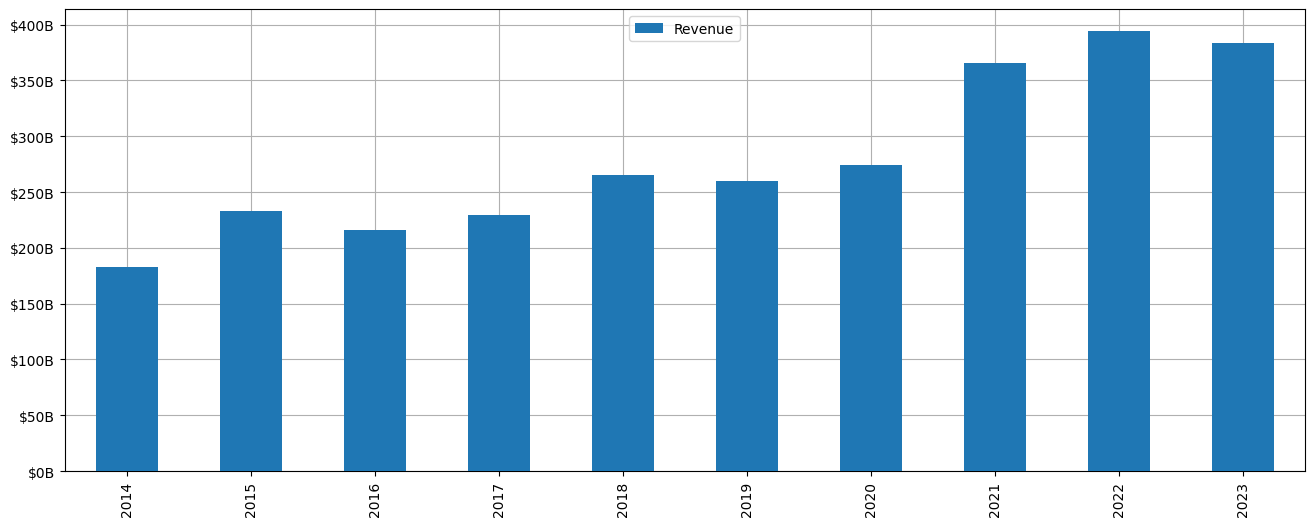

In [60]:
plot_report(annualReports, 'nonInterestIncome', 'Revenue')

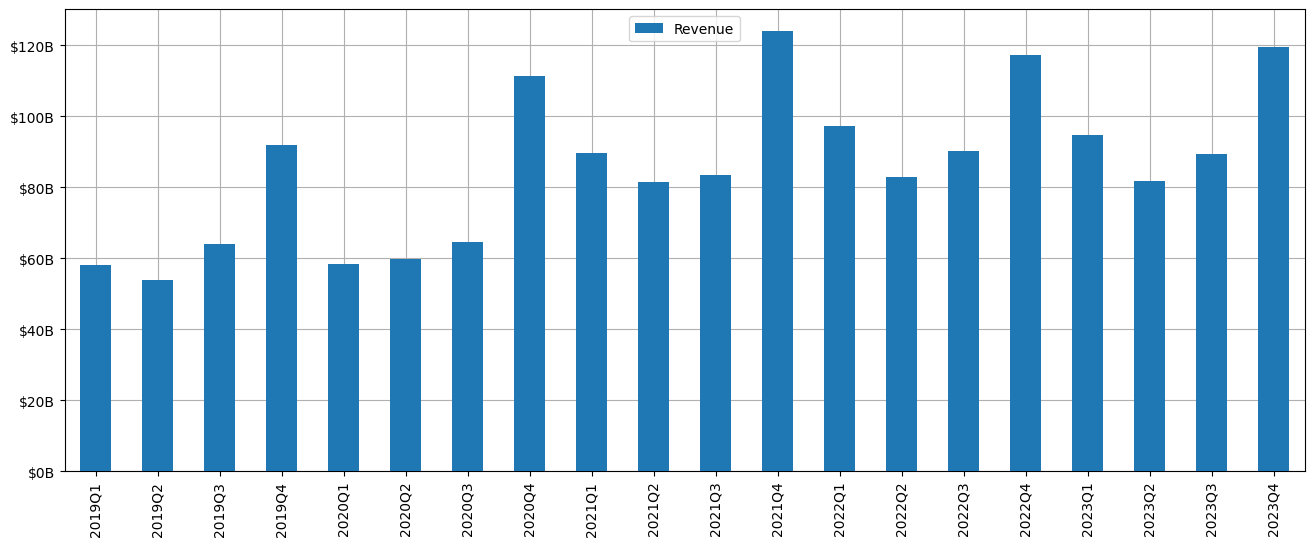

In [61]:
plot_report(quarterlyReports, 'nonInterestIncome', 'Revenue')

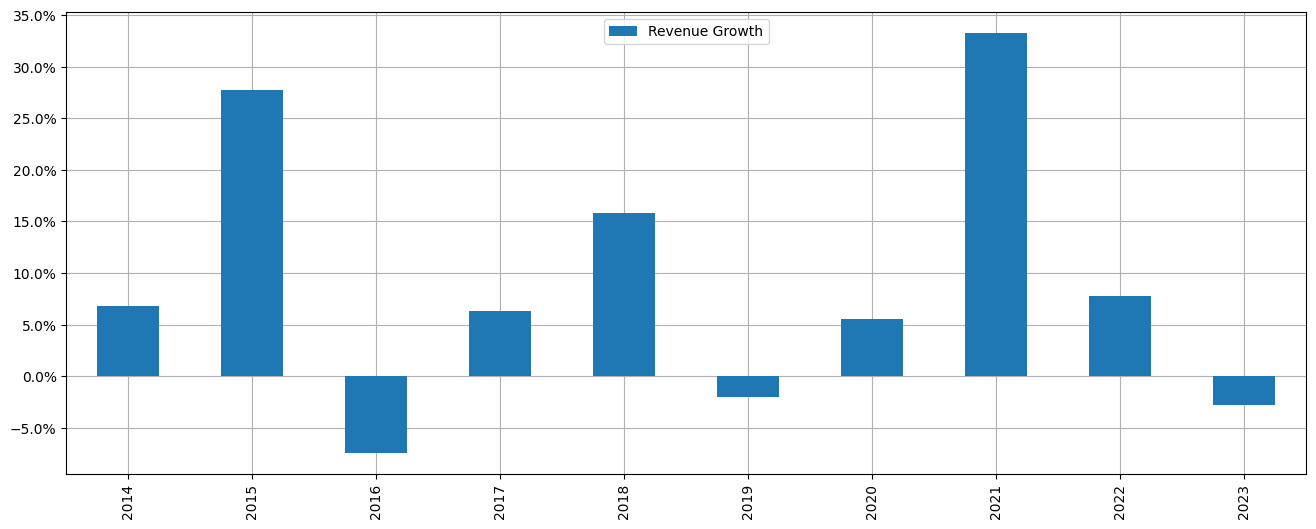

In [62]:
plot_report(annualReports, 'revenueYOYGrowth', 'Revenue Growth')

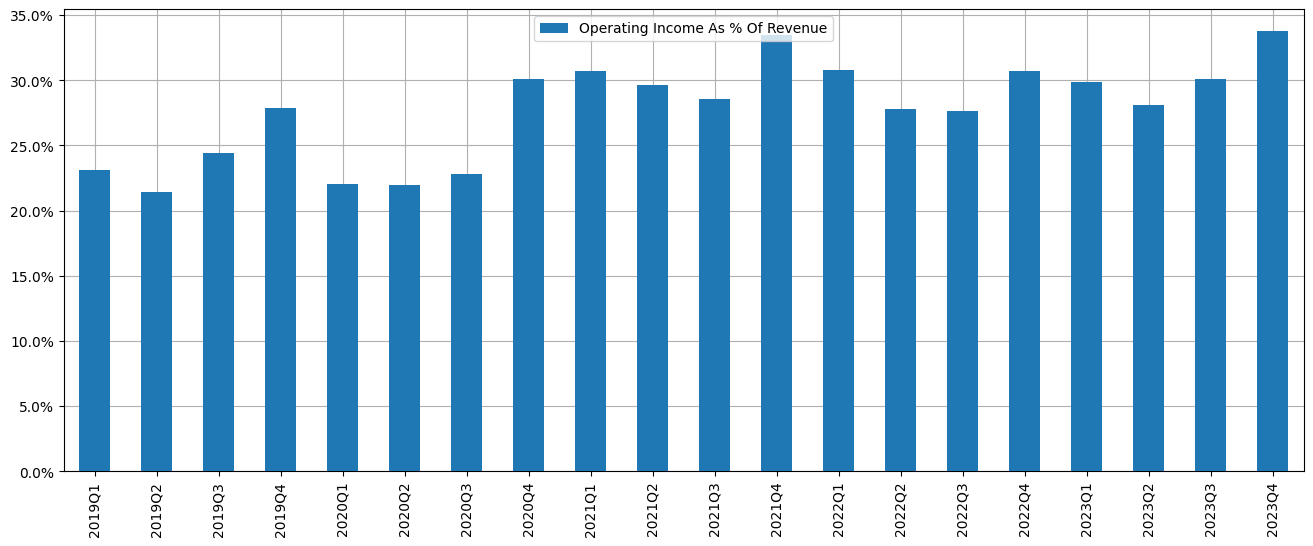

In [63]:
plot_report(quarterlyReports, 'operatingIncomeAs%OfRevenue', 'Operating Income As % Of Revenue')

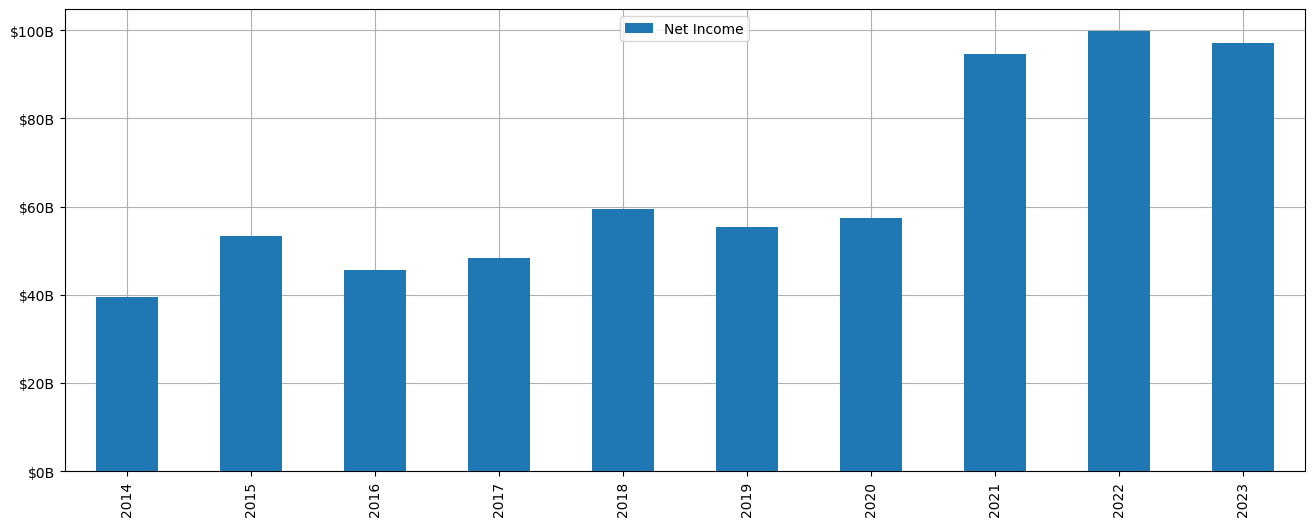

In [64]:
plot_report(annualReports, 'netIncome', 'Net Income')

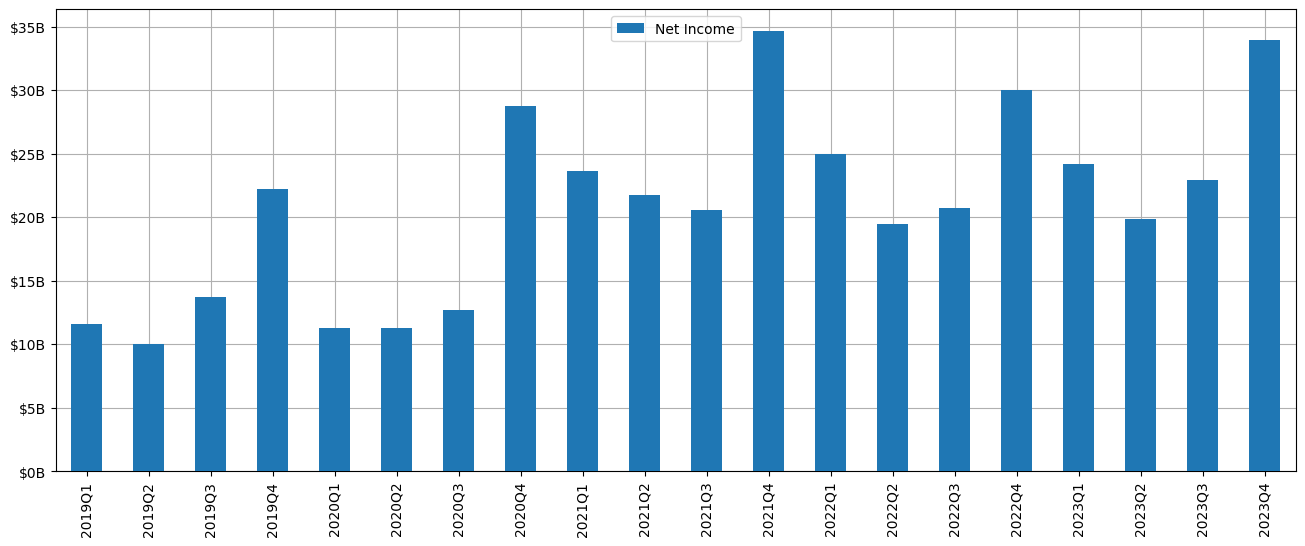

In [65]:
plot_report(quarterlyReports, 'netIncome', 'Net Income')

## Balance Sheet Reports

In [66]:
url = f"https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={symbol}&apikey={ALPHA_VANTAGE_KEY}"
r = requests.get(url)
data = r.json()

In [67]:
def balance_sheet_reports(data, typeReport):
    selected_fields = ['fiscalDateEnding', 'commonStockSharesOutstanding', 'totalAssets', 'totalLiabilities', 'totalShareholderEquity']
    reports = []
    for report in data[typeReport]:
        reports.append({key: report[key] for key in selected_fields})

    df = pd.json_normalize(reports)
    df['fiscalDateEnding'] = pd.to_datetime(df['fiscalDateEnding'])
    df.set_index('fiscalDateEnding', inplace=True)
    df = df.apply(pd.to_numeric)
    df.sort_index(ascending=True, inplace=True)

    if typeReport == 'annualReports':
        df = df.tail(10)
        df.index = df.index.year
    else:
        df = df.tail(20)
        df.index = df.index.to_period('Q')
    
    return df

In [68]:
annualReports = balance_sheet_reports(data, 'annualReports')
quarterlyReports = balance_sheet_reports(data, 'quarterlyReports')

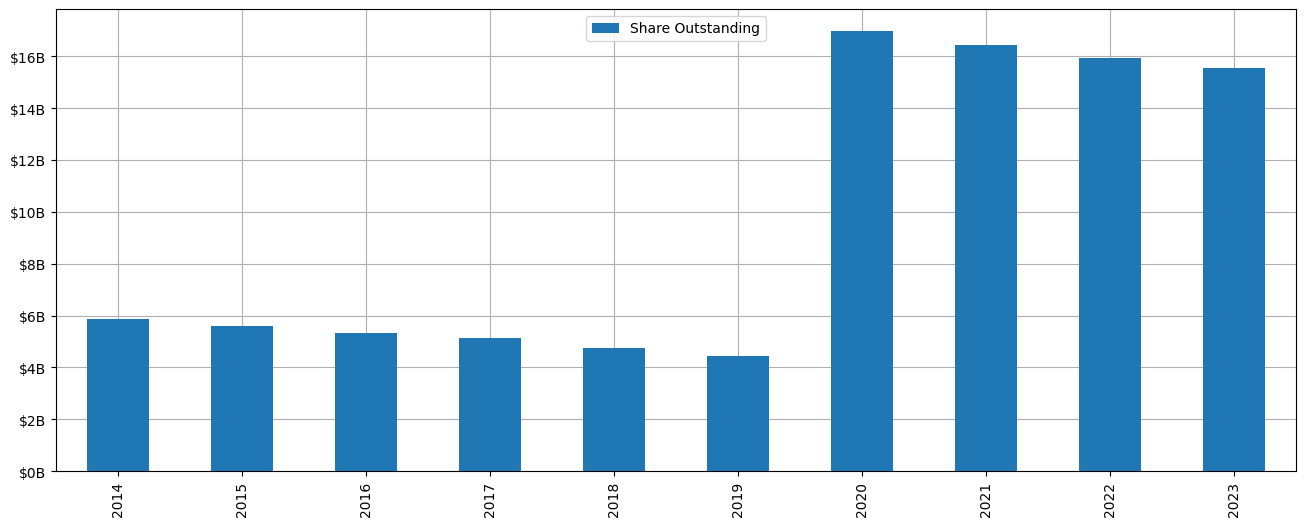

In [69]:
plot_report(annualReports, 'commonStockSharesOutstanding', 'Share Outstanding')

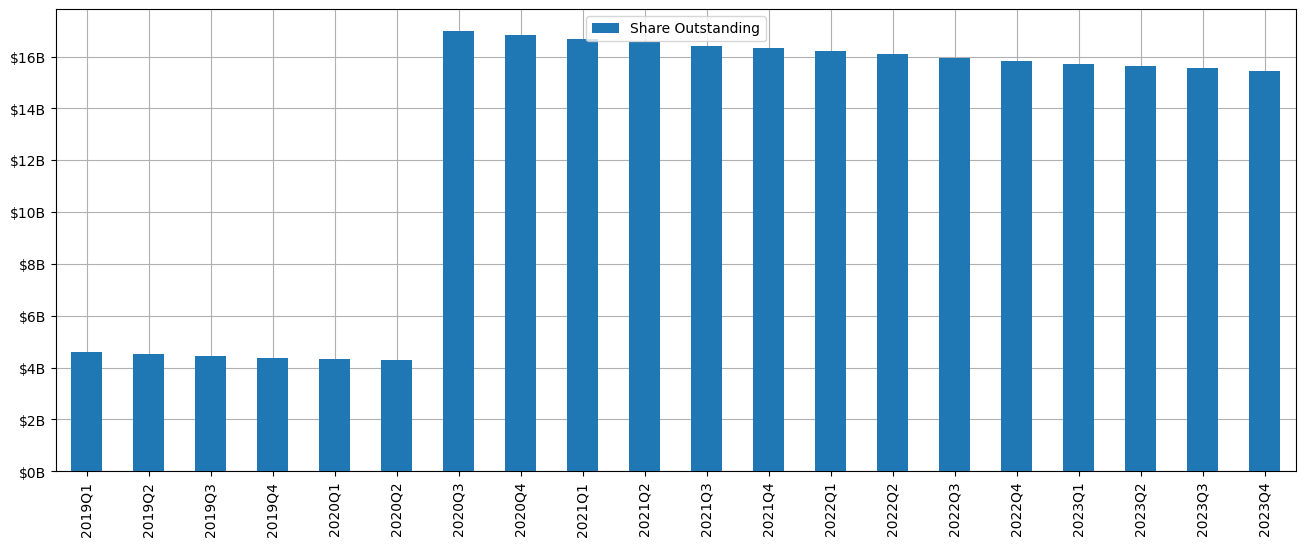

In [70]:
plot_report(quarterlyReports, 'commonStockSharesOutstanding', 'Share Outstanding')

In [71]:
def plot_balance_report(data):
    ax = data[['totalAssets', 'totalLiabilities', 'totalShareholderEquity']].plot.bar(figsize=(16,6), color=['tab:blue', 'tab:red', 'tab:green'], zorder=3)
    ax.grid(zorder=0)
    ax.legend(labels=['totalAssets', 'totalLiabilities', 'totalShareholderEquity'],loc='upper center', fontsize=10, ncol=3)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:1.0f}B'.format(x / 1e9)))
    ax.set_xlabel('')
    plt.show()

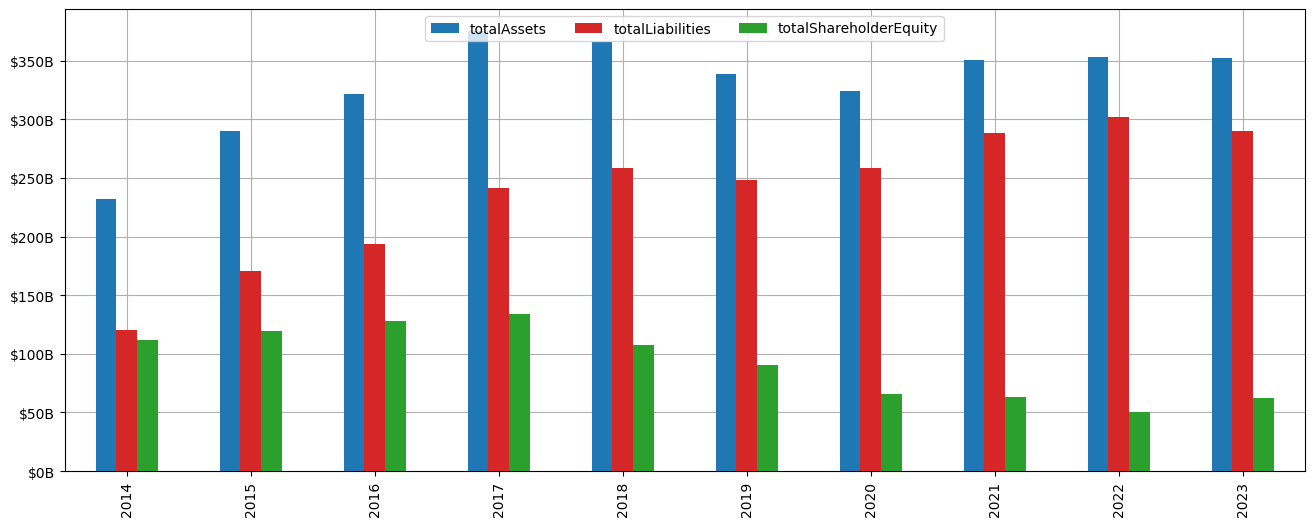

In [72]:
plot_balance_report(annualReports)

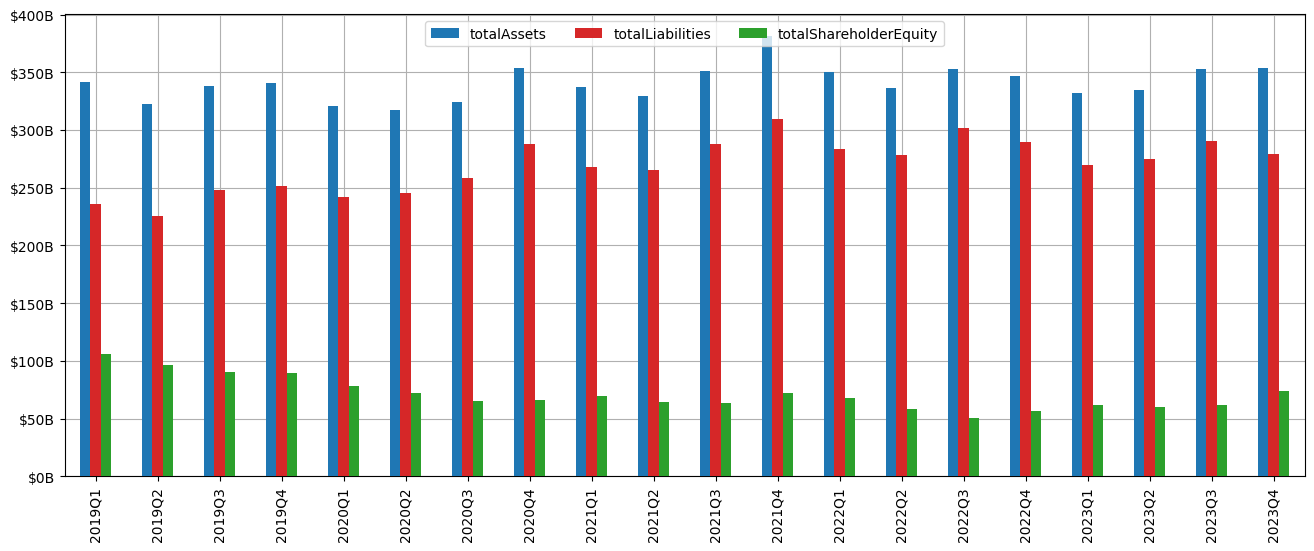

In [51]:
plot_balance_report(quarterlyReports)